In [1]:
import pandas as pd
import numpy as np
from data_prep import create_x_y_data

# Permutation Tests

In [426]:
from data_viz import histogram_plot

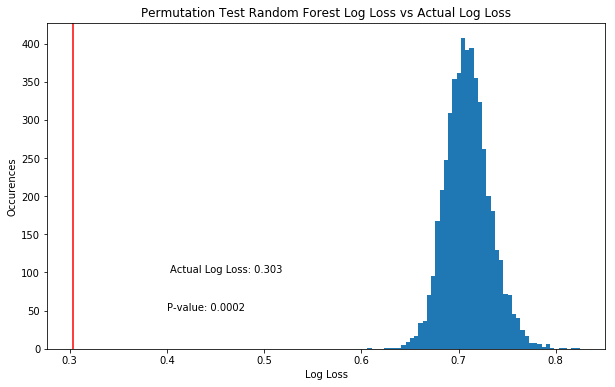

In [427]:
histogram_plot('rf_permutation_test.csv', 'Random Forest', 'log loss')

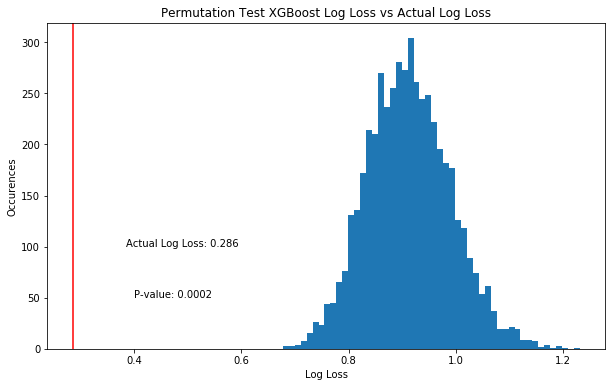

In [428]:
histogram_plot('xgb_permutation_test.csv', 'XGBoost', 'log loss')

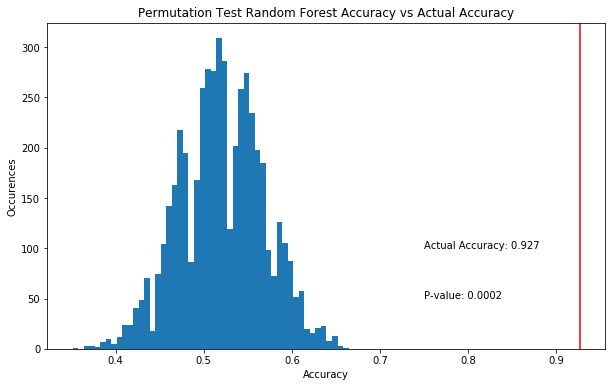

In [429]:
histogram_plot('rf_permutation_acc.csv', 'Random Forest', 'accuracy')

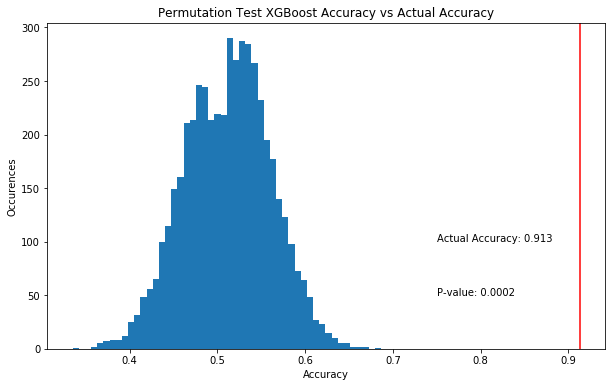

In [430]:
histogram_plot('xgb_permutation_acc.csv', 'XGBoost', 'accuracy')

### Data Prep

In [2]:
X_train, y_train, X_test, y_test, X, y = create_x_y_data()

In [169]:
columns = X_train.columns

# Round 1 (Simple Train/Test Split)

In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

log_model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
log_model.fit(X_train, y_train)
y_pred = log_model.predict_proba(X_test)
log_model_ll = log_loss(y_test, y_pred)

lasso_mask = log_model.coef_ != 0
lasso_columns = columns[lasso_mask[0]]
print(f'Number of Features: {len(lasso_columns)}')
print(f'Lasso Log Loss: {log_model_ll}')

Number of Features: 87
Lasso Log Loss: 0.1690501908927132


In [259]:
from sklearn.ensemble import  RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=8, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)
rf_ll = log_loss(y_test, y_pred)

rf_mask = rf.feature_importances_ != 0
rf_columns = columns[rf_mask]
print(f'Number of Features: {len(rf_columns)}')
print(f'Random Forest Log Loss: {rf_ll}')

Number of Features: 1649
Random Forest Log Loss: 0.2970060960391264


In [260]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 700, random_state=8, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)
xgb_ll = log_loss(y_test, y_pred)

xgb_mask = xgb.feature_importances_ != 0
xgb_columns = columns[xgb_mask]
print(f'Number of Features: {len(xgb_columns)}')
print(f'XGBoost Log Loss: {xgb_ll}')

Number of Features: 241
XGBoost Log Loss: 0.18784231207841498


In [262]:
model_performance = pd.DataFrame({'Model': ['Lasso Regression', 'Random Forest', 'XGBoost'],
                   'Log Loss Performance': [round(log_model_ll, 3), round(rf_ll, 3), round(xgb_ll, 3)],
                   'Number of Weighted Features': [88, 1649, 241]})
model_performance

,Model,Log Loss Performance,Number of Weighted Features
0,Lasso Regression,0.169,88
1,Random Forest,0.297,1649
2,XGBoost,0.188,241


finding intersection of all three models

In [241]:
#gene names
round_1_important = set.intersection(set(lasso_columns), set(xgb_columns), set(rf_columns))
len(round_1_important)

34

In [230]:
# arg position to get the weights
round_1_mask = [x in round_1_important for x in columns]

In [233]:
# using the mask to get the weights of lasso beta coefficients
round_1_weights = log_model.coef_[0][round_1_mask]

In [255]:
# 34 features in xgb found important in the others
xgb_feat_importance = xgb.feature_importances_[round_1_mask]

In [256]:
round_1_df = pd.DataFrame({'Genes': list(round_1_important), 'Lasso Weights': round_1_weights,
                         'XGB Feature Importance': xgb_feat_importance})

In [257]:
round_1_df = round_1_df.sort_values('Lasso Weights')
round_1_df.head()

,Genes,Lasso Weights,XGB Feature Importance
23,ENSG00000172236.15,-0.208293,0.002494
29,ENSG00000178053.16,-0.177475,0.003741
3,ENSG00000167767.12,-0.162847,0.000623
31,ENSG00000230453.8,-0.151761,0.001247
17,ENSG00000156535.12,-0.123340,0.002494


come back here... maybe figure out SHAP values or partial dependency plots...

# Round 2 (Kfold Validation)

Here we are doing kfold with X_train as X_. There are only 88 columns and with five kfolds there
is about 70 rows per fold

### Lasso

In [369]:
# copy X_train and y_train as X_ and y_ for kfold
X_ = X_train.copy()
y_ = y_train.copy()
X_.shape

(88, 1984)

In [391]:
from sklearn.model_selection import train_test_split, KFold

#lasso with kfold validation
log_model = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
kf = KFold(n_splits=5, shuffle=True)

ll_performance = []
model_weights = []
#kfold split on X_ (which is X_train of len 110)
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict_proba(X_test)
    log_ll = log_loss(y_test, y_pred)
    
    ll_performance.append(log_ll)
    model_weights.append(log_model.coef_)    

In [392]:
# note that this average perofmrance is terrible
display(ll_performance)

print(np.mean(ll_performance))

[0.15696299567527752,
 0.34989670330198686,
 0.4900617201911905,
 0.46762820789262044,
 0.060724880359626456]

0.30505490148414033


In [393]:
def important_gene_mask(columns, coefs):
    """
    inputs
    ------
    columns: columns of df
    coefs: beta weights of lasso
    
    results
    ------
    important_genes: name of genes with weight != 0
    gene_weights: beta weights of genes
    """
    
    mask = coefs[0] != 0
    
    gene_weights = coefs[0][mask]
    important_genes = columns[mask]

    return dict(zip(important_genes, gene_weights))

In [394]:
# find the genes with weight != 0 + their weights
l1_dict = important_gene_mask(columns, model_weights[0])
l2_dict = important_gene_mask(columns, model_weights[1])
l3_dict = important_gene_mask(columns, model_weights[2])
l4_dict = important_gene_mask(columns, model_weights[3])
l5_dict = important_gene_mask(columns, model_weights[4])

In [395]:
# find the genes found important in all five kfolds
lasso_gene_intersection = set.intersection(set(l1_dict.keys()), set(l2_dict.keys()), set(l3_dict.keys()),
                            set(l5_dict.keys()), set(l4_dict.keys()))
len(lasso_gene_intersection)

11

In [396]:
# find average weight for the 15 genes
lasso_average_weight = {}
for gene in lasso_gene_intersection:
    lasso_average_weight[gene] = l1_dict[gene]
    lasso_average_weight[gene] += l2_dict[gene]
    lasso_average_weight[gene] += l3_dict[gene]
    lasso_average_weight[gene] += l4_dict[gene]
    lasso_average_weight[gene] += l5_dict[gene]
    lasso_average_weight[gene] = lasso_average_weight[gene]/5
lasso_average_weight

{'ENSG00000078399.14': -0.13348699301066852,
 'ENSG00000165092.11': -0.05146185196140503,
 'ENSG00000120833.12': -0.06523665266352362,
 'ENSG00000279717.1': 0.04913290177574141,
 'ENSG00000106004.4': -0.06349579751524403,
 'ENSG00000120279.6': -0.048119548611474036,
 'ENSG00000250696.4': 0.11039005675518432,
 'ENSG00000249763.1': 0.06781987277506187,
 'ENSG00000253293.4': -0.11654455203640565,
 'ENSG00000198722.11': -0.14714501294848495,
 'ENSG00000271952.1': -0.0849049372411359}

### Random Forest/XGB

In [384]:
xgb = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 500, random_state=8, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=1000, max_depth=15, random_state=8, n_jobs=-1)

kf = KFold(n_splits=5, shuffle=True)

rf_ll_performance = []
xgb_ll_performance = []

rf_weights = []
xgb_weights = []


for train_index, test_index in kf.split(X_):
    X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
    
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)

    p_rf = rf.predict_proba(X_test)
    p_xgb = xgb.predict_proba(X_test)

    rf_ll = log_loss(y_test, p_rf)
    xgb_ll = log_loss(y_test, p_xgb)

    
    rf_ll_performance.append(rf_ll)
    xgb_ll_performance.append(xgb_ll)
    
    rf_weights.append(rf.feature_importances_)
    xgb_weights.append(xgb.feature_importances_)

In [385]:
display(rf_ll_performance)
print(f'Average RF Log Loss: {np.mean(rf_ll_performance)}')

display(xgb_ll_performance)
print(f'Average XGB Log Loss: {np.mean(xgb_ll_performance)}')

[0.2620089183833226,
 0.235389479810502,
 0.4553468693742644,
 0.31334393960014995,
 0.3674390830878708]

Average RF Log Loss: 0.326705658051222


[0.2027618751550714,
 0.2732902831501431,
 0.5566072581956784,
 0.16107876434483948,
 0.3562459001208053]

Average XGB Log Loss: 0.30999681619330755


can tune these later...

In [397]:
def important_gene_mask_tree(columns, coefs):
    """
    gene finder for tree based models since coef_ and feature_importances
    work differently.
    
    inputs
    ------
    columns: columns of df
    coefs: beta weights of lasso
    
    results
    ------
    important_genes: name of genes with weight != 0
    gene_weights: beta weights of genes
    """
    
    mask = coefs != 0
    
    gene_weights = coefs[mask]
    important_genes = columns[mask]

    return dict(zip(important_genes, gene_weights))

#### XGBoost

In [400]:
xgb1_dict = important_gene_mask_tree(columns, xgb_weights[0])
xgb2_dict = important_gene_mask_tree(columns, xgb_weights[1])
xgb3_dict = important_gene_mask_tree(columns, xgb_weights[2])
xgb4_dict = important_gene_mask_tree(columns, xgb_weights[3])
xgb5_dict = important_gene_mask_tree(columns, xgb_weights[4])

In [401]:
# find the genes found important in all five kfolds
xgb_gene_intersection = set.intersection(set(xgb1_dict.keys()), set(xgb2_dict.keys()), set(xgb3_dict.keys()),
                            set(xgb4_dict.keys()), set(xgb5_dict.keys()))
#number of genes in each round
print(len(xgb_gene_intersection))

# find average weight for the 12 xgb genes
xgb_average_weight = {}
for gene in xgb_gene_intersection:
    xgb_average_weight[gene] = xgb1_dict[gene]
    xgb_average_weight[gene] += xgb2_dict[gene]
    xgb_average_weight[gene] += xgb3_dict[gene]
    xgb_average_weight[gene] += xgb5_dict[gene]
    xgb_average_weight[gene] += xgb5_dict[gene]
    xgb_average_weight[gene] = xgb_average_weight[gene]/5
xgb_average_weight

4


{'ENSG00000246985.6': 0.016516770422458648,
 'ENSG00000163106.9': 0.1468716025352478,
 'ENSG00000137474.18': 0.01309700906276703,
 'ENSG00000277435.1': 0.06050815582275391}

#### Random Forest

In [402]:
rf1_dict = important_gene_mask_tree(columns, rf_weights[0])
rf2_dict = important_gene_mask_tree(columns, rf_weights[1])
rf3_dict = important_gene_mask_tree(columns, rf_weights[2])
rf4_dict = important_gene_mask_tree(columns, rf_weights[3])
rf5_dict = important_gene_mask_tree(columns, rf_weights[4])

# find the genes found important in all five kfolds
rf_gene_intersection = set.intersection(set(rf1_dict.keys()), set(rf2_dict.keys()), set(rf3_dict.keys()),
                            set(rf4_dict.keys()), set(rf5_dict.keys()))
#number of genes in each round
print(len(rf_gene_intersection))

# find average weight for the 12 xgb genes
rf_average_weight = {}
for gene in rf_gene_intersection:
    rf_average_weight[gene] = rf1_dict[gene]
    rf_average_weight[gene] += rf2_dict[gene]
    rf_average_weight[gene] += rf3_dict[gene]
    rf_average_weight[gene] += rf5_dict[gene]
    rf_average_weight[gene] += rf5_dict[gene]
    rf_average_weight[gene] = rf_average_weight[gene]/5
rf_average_weight

640


{'ENSG00000104951.14': 0.0019036755157611108,
 'ENSG00000237945.6': 0.0001886413578580367,
 'ENSG00000149260.13': 0.0013105961103675782,
 'ENSG00000249252.4': 0.0005396921392629356,
 'ENSG00000106484.13': 0.000407680642207917,
 'ENSG00000148773.11': 0.00010266931557283515,
 'ENSG00000134569.8': 0.002976444024992092,
 'ENSG00000046889.17': 0.00020071095143027175,
 'ENSG00000088305.17': 0.0002468822017169817,
 'ENSG00000271109.1': 0.0008422576616973852,
 'ENSG00000123552.16': 0.00030830523571919875,
 'ENSG00000129757.11': 0.0002140633567298507,
 'ENSG00000206120.10': 0.000826115656216028,
 'ENSG00000010319.5': 0.0014264254463949157,
 'ENSG00000179583.16': 0.0007320768355499893,
 'ENSG00000225792.1': 0.002607913113724419,
 'ENSG00000081377.15': 0.0023864822660333886,
 'ENSG00000272620.1': 0.00011916589972338687,
 'ENSG00000119280.15': 0.00031299618576405915,
 'ENSG00000007038.9': 0.00020506837215647947,
 'ENSG00000254369.5': 0.01906431556385057,
 'ENSG00000132975.7': 0.006223882430366458,

In [410]:
# no intersection between 11 lasso and 4 xgb features
display(set.intersection(set(xgb_gene_intersection), set(lasso_gene_intersection)))

# union of xgb and lasso features
set.union(set(xgb_gene_intersection), set(lasso_gene_intersection))

set()

{'ENSG00000078399.14',
 'ENSG00000106004.4',
 'ENSG00000120279.6',
 'ENSG00000120833.12',
 'ENSG00000137474.18',
 'ENSG00000163106.9',
 'ENSG00000165092.11',
 'ENSG00000198722.11',
 'ENSG00000246985.6',
 'ENSG00000249763.1',
 'ENSG00000250696.4',
 'ENSG00000253293.4',
 'ENSG00000271952.1',
 'ENSG00000277435.1',
 'ENSG00000279717.1'}

In [412]:
# check for large weights
display(xgb_average_weight)

display(lasso_average_weight)

{'ENSG00000246985.6': 0.016516770422458648,
 'ENSG00000163106.9': 0.1468716025352478,
 'ENSG00000137474.18': 0.01309700906276703,
 'ENSG00000277435.1': 0.06050815582275391}

{'ENSG00000078399.14': -0.13348699301066852,
 'ENSG00000165092.11': -0.05146185196140503,
 'ENSG00000120833.12': -0.06523665266352362,
 'ENSG00000279717.1': 0.04913290177574141,
 'ENSG00000106004.4': -0.06349579751524403,
 'ENSG00000120279.6': -0.048119548611474036,
 'ENSG00000250696.4': 0.11039005675518432,
 'ENSG00000249763.1': 0.06781987277506187,
 'ENSG00000253293.4': -0.11654455203640565,
 'ENSG00000198722.11': -0.14714501294848495,
 'ENSG00000271952.1': -0.0849049372411359}

In [413]:
kfold_model_performance = pd.DataFrame({'Model': ['Lasso Regression', 'Random Forest', 'XGBoost'],
                                        'Log Loss Performance': [round(np.mean(ll_performance), 3), 
                                                                round(np.mean(rf_ll_performance), 3),
                                                                round(np.mean(xgb_ll_performance), 3)],
                                        'KFold Features': [11, 640, 4]})

In [414]:
kfold_model_performance

,Model,Log Loss Performance,KFold Features
0,Lasso Regression,0.305,11
1,Random Forest,0.327,640
2,XGBoost,0.310,4


tune and then do the same with model weights

# Round 3: Boruta

how well does Boruta select features based on X_train

then predict RF/XGboost on those features

In [422]:
from boruta import BorutaPy

rf_boruta = RandomForestClassifier(n_jobs=-1)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=2, max_iter = 200, random_state=8)
feat_selector.fit(X_train.values, y_train.values)

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	0
Tentative: 	427
Rejected: 	1557


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 200
Confirmed: 	40
Tentative: 	387
Rejected: 	1557


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 200
Confirmed: 	40
Tentative: 	387
Rejected: 	1557


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 200
Confirmed: 	40
Tentative: 	387
Rejected: 	1557


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 200
Confirmed: 	49
Tentative: 	281
Rejected: 	1654


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 200
Confirmed: 	49
Tentative: 	281
Rejected: 	1654


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 200
Confirmed: 	49
Tentative: 	281
Rejected: 	1654


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 200
Confirmed: 	49
Tentative: 	281
Rejected: 	1654


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 200
Confirmed: 	54
Tentative: 	236
Rejected: 	1694


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 200
Confirmed: 	54
Tentative: 	236
Rejected: 	1694


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 200
Confirmed: 	54
Tentative: 	236
Rejected: 	1694


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 200
Confirmed: 	56
Tentative: 	194
Rejected: 	1734


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 200
Confirmed: 	56
Tentative: 	194
Rejected: 	1734


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 200
Confirmed: 	56
Tentative: 	194
Rejected: 	1734


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 200
Confirmed: 	57
Tentative: 	172
Rejected: 	1755


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 200
Confirmed: 	57
Tentative: 	172
Rejected: 	1755


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 200
Confirmed: 	57
Tentative: 	172
Rejected: 	1755


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 200
Confirmed: 	57
Tentative: 	172
Rejected: 	1755


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 200
Confirmed: 	58
Tentative: 	162
Rejected: 	1764


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 200
Confirmed: 	58
Tentative: 	162
Rejected: 	1764


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 200
Confirmed: 	58
Tentative: 	162
Rejected: 	1764


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 200
Confirmed: 	58
Tentative: 	148
Rejected: 	1778


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 200
Confirmed: 	58
Tentative: 	148
Rejected: 	1778


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 200
Confirmed: 	58
Tentative: 	148
Rejected: 	1778


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 200
Confirmed: 	59
Tentative: 	138
Rejected: 	1787


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 200
Confirmed: 	59
Tentative: 	138
Rejected: 	1787


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 200
Confirmed: 	59
Tentative: 	132
Rejected: 	1793


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 200
Confirmed: 	59
Tentative: 	132
Rejected: 	1793


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 200
Confirmed: 	59
Tentative: 	132
Rejected: 	1793


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 200
Confirmed: 	59
Tentative: 	123
Rejected: 	1802


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 200
Confirmed: 	59
Tentative: 	123
Rejected: 	1802


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 200
Confirmed: 	59
Tentative: 	123
Rejected: 	1802


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 200
Confirmed: 	59
Tentative: 	117
Rejected: 	1808


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 200
Confirmed: 	59
Tentative: 	117
Rejected: 	1808


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 200
Confirmed: 	59
Tentative: 	117
Rejected: 	1808


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 200
Confirmed: 	59
Tentative: 	113
Rejected: 	1812


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 200
Confirmed: 	59
Tentative: 	113
Rejected: 	1812


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 200
Confirmed: 	59
Tentative: 	113
Rejected: 	1812


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 200
Confirmed: 	59
Tentative: 	107
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 200
Confirmed: 	59
Tentative: 	107
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 200
Confirmed: 	59
Tentative: 	107
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 200
Confirmed: 	59
Tentative: 	106
Rejected: 	1819


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 200
Confirmed: 	59
Tentative: 	106
Rejected: 	1819


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 200
Confirmed: 	60
Tentative: 	102
Rejected: 	1822


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 200
Confirmed: 	60
Tentative: 	102
Rejected: 	1822


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 200
Confirmed: 	60
Tentative: 	102
Rejected: 	1822


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 200
Confirmed: 	60
Tentative: 	98
Rejected: 	1826


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 200
Confirmed: 	60
Tentative: 	98
Rejected: 	1826


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 200
Confirmed: 	60
Tentative: 	98
Rejected: 	1826


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 200
Confirmed: 	62
Tentative: 	95
Rejected: 	1827


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 200
Confirmed: 	62
Tentative: 	95
Rejected: 	1827


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 200
Confirmed: 	62
Tentative: 	92
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 200
Confirmed: 	62
Tentative: 	92
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 200
Confirmed: 	62
Tentative: 	92
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 200
Confirmed: 	62
Tentative: 	87
Rejected: 	1835


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 200
Confirmed: 	62
Tentative: 	87
Rejected: 	1835


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 200
Confirmed: 	62
Tentative: 	87
Rejected: 	1835


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 200
Confirmed: 	62
Tentative: 	86
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 200
Confirmed: 	62
Tentative: 	86
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 200
Confirmed: 	62
Tentative: 	84
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 200
Confirmed: 	62
Tentative: 	84
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 200
Confirmed: 	62
Tentative: 	84
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 200
Confirmed: 	62
Tentative: 	84
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 200
Confirmed: 	62
Tentative: 	83
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 200
Confirmed: 	62
Tentative: 	83
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 200
Confirmed: 	62
Tentative: 	83
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 200
Confirmed: 	62
Tentative: 	83
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 200
Confirmed: 	62
Tentative: 	82
Rejected: 	1840


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 200
Confirmed: 	62
Tentative: 	82
Rejected: 	1840


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 200
Confirmed: 	62
Tentative: 	80
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 200
Confirmed: 	62
Tentative: 	80
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 200
Confirmed: 	62
Tentative: 	80
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 200
Confirmed: 	63
Tentative: 	79
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 200
Confirmed: 	63
Tentative: 	79
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 200
Confirmed: 	63
Tentative: 	79
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 200
Confirmed: 	63
Tentative: 	79
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 200
Confirmed: 	63
Tentative: 	79
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 200
Confirmed: 	65
Tentative: 	77
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 200
Confirmed: 	65
Tentative: 	77
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 200
Confirmed: 	65
Tentative: 	77
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 200
Confirmed: 	65
Tentative: 	75
Rejected: 	1844


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 200
Confirmed: 	65
Tentative: 	75
Rejected: 	1844


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 200
Confirmed: 	65
Tentative: 	75
Rejected: 	1844


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 200
Confirmed: 	65
Tentative: 	75
Rejected: 	1844


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 200
Confirmed: 	65
Tentative: 	75
Rejected: 	1844


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 200
Confirmed: 	65
Tentative: 	74
Rejected: 	1845


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 200
Confirmed: 	65
Tentative: 	74
Rejected: 	1845


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 200
Confirmed: 	65
Tentative: 	73
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 200
Confirmed: 	65
Tentative: 	73
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 200
Confirmed: 	65
Tentative: 	73
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	99 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	100 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	101 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	102 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	103 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	104 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	105 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	106 / 200
Confirmed: 	65
Tentative: 	72
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	107 / 200
Confirmed: 	65
Tentative: 	71
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	108 / 200
Confirmed: 	65
Tentative: 	71
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	109 / 200
Confirmed: 	65
Tentative: 	71
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	110 / 200
Confirmed: 	65
Tentative: 	71
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	111 / 200
Confirmed: 	65
Tentative: 	71
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	112 / 200
Confirmed: 	65
Tentative: 	71
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	113 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	114 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	115 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	116 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	117 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	118 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	119 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	120 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	121 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	122 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	123 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	124 / 200
Confirmed: 	65
Tentative: 	70
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	125 / 200
Confirmed: 	65
Tentative: 	69
Rejected: 	1850


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	126 / 200
Confirmed: 	65
Tentative: 	69
Rejected: 	1850


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	127 / 200
Confirmed: 	65
Tentative: 	68
Rejected: 	1851


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	128 / 200
Confirmed: 	65
Tentative: 	68
Rejected: 	1851


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	129 / 200
Confirmed: 	65
Tentative: 	68
Rejected: 	1851


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	130 / 200
Confirmed: 	65
Tentative: 	68
Rejected: 	1851


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	131 / 200
Confirmed: 	65
Tentative: 	68
Rejected: 	1851


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	132 / 200
Confirmed: 	65
Tentative: 	67
Rejected: 	1852


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	133 / 200
Confirmed: 	65
Tentative: 	67
Rejected: 	1852


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	134 / 200
Confirmed: 	65
Tentative: 	65
Rejected: 	1854


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	135 / 200
Confirmed: 	65
Tentative: 	65
Rejected: 	1854


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	136 / 200
Confirmed: 	65
Tentative: 	65
Rejected: 	1854


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	137 / 200
Confirmed: 	65
Tentative: 	65
Rejected: 	1854


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	138 / 200
Confirmed: 	65
Tentative: 	65
Rejected: 	1854


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	139 / 200
Confirmed: 	66
Tentative: 	63
Rejected: 	1855


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	140 / 200
Confirmed: 	66
Tentative: 	63
Rejected: 	1855


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	141 / 200
Confirmed: 	66
Tentative: 	62
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	142 / 200
Confirmed: 	66
Tentative: 	62
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	143 / 200
Confirmed: 	66
Tentative: 	62
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	144 / 200
Confirmed: 	66
Tentative: 	61
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	145 / 200
Confirmed: 	66
Tentative: 	61
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	146 / 200
Confirmed: 	66
Tentative: 	61
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	147 / 200
Confirmed: 	66
Tentative: 	61
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	148 / 200
Confirmed: 	66
Tentative: 	61
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	149 / 200
Confirmed: 	66
Tentative: 	59
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	150 / 200
Confirmed: 	66
Tentative: 	59
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	151 / 200
Confirmed: 	66
Tentative: 	59
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	152 / 200
Confirmed: 	66
Tentative: 	59
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	153 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	154 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	155 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	156 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	157 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	158 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	159 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	160 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	161 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	162 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	163 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	164 / 200
Confirmed: 	66
Tentative: 	58
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	165 / 200
Confirmed: 	66
Tentative: 	56
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	166 / 200
Confirmed: 	66
Tentative: 	56
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	167 / 200
Confirmed: 	66
Tentative: 	56
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	168 / 200
Confirmed: 	66
Tentative: 	56
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	169 / 200
Confirmed: 	66
Tentative: 	56
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	170 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	171 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	172 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	173 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	174 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	175 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	176 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	177 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	178 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	179 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	180 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	181 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	182 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	183 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	184 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	185 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	186 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	187 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	188 / 200
Confirmed: 	66
Tentative: 	53
Rejected: 	1865


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	189 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	190 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	191 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	192 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	193 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	194 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	195 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	196 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	197 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	198 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866
Iteration: 	199 / 200
Confirmed: 	66
Tentative: 	52
Rejected: 	1866


BorutaPy finished running.

Iteration: 	200 / 200
Confirmed: 	66
Tentative: 	21
Rejected: 	1866


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=153, n_jobs=-1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x1a18aef1f8>,
            verbose=0, warm_start=False),
     max_iter=200, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x1a18aef1f8>,
     two_step=True, verbose=2)

In [423]:
selected = X_train.values[:, feat_selector.support_]
print(selected.shape)

# get the name of columns that boruta thinks is important
boruta_mask = feat_selector.support_
rf_boruta_features_train = columns[boruta_mask]

(71, 66)


In [424]:
rf_boruta = RandomForestClassifier(n_jobs=-1)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=2, max_iter = 200, random_state=8)
feat_selector.fit(X.values, y.values)

selected = X.values[:, feat_selector.support_]
print(selected.shape)

# get the name of columns that boruta thinks is important
boruta_mask = feat_selector.support_
rf_boruta_features = columns[boruta_mask]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	0
Tentative: 	581
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 200
Confirmed: 	65
Tentative: 	516
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 200
Confirmed: 	65
Tentative: 	516
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 200
Confirmed: 	65
Tentative: 	516
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 200
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 200
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 200
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 200
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 200
Confirmed: 	75
Tentative: 	259
Rejected: 	1650


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 200
Confirmed: 	75
Tentative: 	259
Rejected: 	1650


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 200
Confirmed: 	75
Tentative: 	259
Rejected: 	1650


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 200
Confirmed: 	77
Tentative: 	218
Rejected: 	1689


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 200
Confirmed: 	77
Tentative: 	218
Rejected: 	1689


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 200
Confirmed: 	77
Tentative: 	218
Rejected: 	1689


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 200
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 200
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 200
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 200
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 200
Confirmed: 	77
Tentative: 	176
Rejected: 	1731


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 200
Confirmed: 	77
Tentative: 	176
Rejected: 	1731


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 200
Confirmed: 	77
Tentative: 	176
Rejected: 	1731


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 200
Confirmed: 	79
Tentative: 	160
Rejected: 	1745


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 200
Confirmed: 	79
Tentative: 	160
Rejected: 	1745


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 200
Confirmed: 	79
Tentative: 	160
Rejected: 	1745


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 200
Confirmed: 	79
Tentative: 	154
Rejected: 	1751


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 200
Confirmed: 	79
Tentative: 	154
Rejected: 	1751


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 200
Confirmed: 	80
Tentative: 	142
Rejected: 	1762


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 200
Confirmed: 	80
Tentative: 	142
Rejected: 	1762


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 200
Confirmed: 	80
Tentative: 	142
Rejected: 	1762


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 200
Confirmed: 	82
Tentative: 	133
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 200
Confirmed: 	82
Tentative: 	133
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 200
Confirmed: 	82
Tentative: 	133
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 200
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 200
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 200
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 200
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 200
Confirmed: 	84
Tentative: 	121
Rejected: 	1779


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 200
Confirmed: 	84
Tentative: 	121
Rejected: 	1779


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 200
Confirmed: 	84
Tentative: 	116
Rejected: 	1784


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 200
Confirmed: 	84
Tentative: 	116
Rejected: 	1784


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 200
Confirmed: 	84
Tentative: 	116
Rejected: 	1784


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 200
Confirmed: 	84
Tentative: 	111
Rejected: 	1789


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 200
Confirmed: 	84
Tentative: 	111
Rejected: 	1789


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 200
Confirmed: 	84
Tentative: 	105
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 200
Confirmed: 	84
Tentative: 	105
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 200
Confirmed: 	84
Tentative: 	105
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 200
Confirmed: 	84
Tentative: 	103
Rejected: 	1797


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 200
Confirmed: 	84
Tentative: 	103
Rejected: 	1797


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 200
Confirmed: 	84
Tentative: 	103
Rejected: 	1797


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 200
Confirmed: 	84
Tentative: 	100
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 200
Confirmed: 	84
Tentative: 	100
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 200
Confirmed: 	84
Tentative: 	95
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 200
Confirmed: 	84
Tentative: 	95
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 200
Confirmed: 	84
Tentative: 	95
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 200
Confirmed: 	84
Tentative: 	94
Rejected: 	1806


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 200
Confirmed: 	84
Tentative: 	94
Rejected: 	1806


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 200
Confirmed: 	84
Tentative: 	94
Rejected: 	1806


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 200
Confirmed: 	84
Tentative: 	91
Rejected: 	1809


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 200
Confirmed: 	84
Tentative: 	91
Rejected: 	1809


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 200
Confirmed: 	84
Tentative: 	82
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 200
Confirmed: 	84
Tentative: 	82
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 200
Confirmed: 	84
Tentative: 	82
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 200
Confirmed: 	84
Tentative: 	80
Rejected: 	1820


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 200
Confirmed: 	84
Tentative: 	80
Rejected: 	1820


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 200
Confirmed: 	84
Tentative: 	77
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 200
Confirmed: 	84
Tentative: 	77
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 200
Confirmed: 	84
Tentative: 	77
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 200
Confirmed: 	84
Tentative: 	73
Rejected: 	1827


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 200
Confirmed: 	84
Tentative: 	73
Rejected: 	1827


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 200
Confirmed: 	84
Tentative: 	71
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 200
Confirmed: 	84
Tentative: 	71
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 200
Confirmed: 	84
Tentative: 	71
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 200
Confirmed: 	84
Tentative: 	68
Rejected: 	1832


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 200
Confirmed: 	84
Tentative: 	68
Rejected: 	1832


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 200
Confirmed: 	84
Tentative: 	68
Rejected: 	1832


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 200
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 200
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 200
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 200
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 200
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 200
Confirmed: 	84
Tentative: 	66
Rejected: 	1834


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 200
Confirmed: 	84
Tentative: 	66
Rejected: 	1834


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 200
Confirmed: 	84
Tentative: 	62
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 200
Confirmed: 	84
Tentative: 	62
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 200
Confirmed: 	84
Tentative: 	62
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 200
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 200
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 200
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 200
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 200
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 200
Confirmed: 	85
Tentative: 	59
Rejected: 	1840


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	99 / 200
Confirmed: 	85
Tentative: 	59
Rejected: 	1840


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	100 / 200
Confirmed: 	85
Tentative: 	57
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	101 / 200
Confirmed: 	85
Tentative: 	57
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	102 / 200
Confirmed: 	85
Tentative: 	57
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	103 / 200
Confirmed: 	85
Tentative: 	56
Rejected: 	1843


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	104 / 200
Confirmed: 	85
Tentative: 	56
Rejected: 	1843


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	105 / 200
Confirmed: 	85
Tentative: 	55
Rejected: 	1844


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	106 / 200
Confirmed: 	85
Tentative: 	55
Rejected: 	1844


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	107 / 200
Confirmed: 	85
Tentative: 	53
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	108 / 200
Confirmed: 	85
Tentative: 	53
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	109 / 200
Confirmed: 	85
Tentative: 	53
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	110 / 200
Confirmed: 	85
Tentative: 	52
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	111 / 200
Confirmed: 	85
Tentative: 	52
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	112 / 200
Confirmed: 	85
Tentative: 	51
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	113 / 200
Confirmed: 	85
Tentative: 	51
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	114 / 200
Confirmed: 	85
Tentative: 	51
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	115 / 200
Confirmed: 	85
Tentative: 	51
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	116 / 200
Confirmed: 	85
Tentative: 	51
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	117 / 200
Confirmed: 	85
Tentative: 	50
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	118 / 200
Confirmed: 	85
Tentative: 	50
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	119 / 200
Confirmed: 	85
Tentative: 	50
Rejected: 	1849


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	120 / 200
Confirmed: 	85
Tentative: 	48
Rejected: 	1851


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	121 / 200
Confirmed: 	85
Tentative: 	48
Rejected: 	1851


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	122 / 200
Confirmed: 	85
Tentative: 	47
Rejected: 	1852


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	123 / 200
Confirmed: 	85
Tentative: 	47
Rejected: 	1852


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	124 / 200
Confirmed: 	85
Tentative: 	47
Rejected: 	1852


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	125 / 200
Confirmed: 	85
Tentative: 	47
Rejected: 	1852


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	126 / 200
Confirmed: 	85
Tentative: 	47
Rejected: 	1852


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	127 / 200
Confirmed: 	85
Tentative: 	44
Rejected: 	1855


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	128 / 200
Confirmed: 	85
Tentative: 	44
Rejected: 	1855


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	129 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	130 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	131 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	132 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	133 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	134 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	135 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	136 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	137 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	138 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	139 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	140 / 200
Confirmed: 	85
Tentative: 	43
Rejected: 	1856


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	141 / 200
Confirmed: 	85
Tentative: 	42
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	142 / 200
Confirmed: 	85
Tentative: 	42
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	143 / 200
Confirmed: 	85
Tentative: 	42
Rejected: 	1857


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	144 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	145 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	146 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	147 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	148 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	149 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	150 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	151 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	152 / 200
Confirmed: 	85
Tentative: 	41
Rejected: 	1858


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	153 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	154 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	155 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	156 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	157 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	158 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	159 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	160 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	161 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	162 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	163 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	164 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	165 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	166 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	167 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	168 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	169 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	170 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	171 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	172 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	173 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	174 / 200
Confirmed: 	85
Tentative: 	40
Rejected: 	1859


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	175 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	176 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	177 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	178 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	179 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	180 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	181 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	182 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	183 / 200
Confirmed: 	85
Tentative: 	39
Rejected: 	1860


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	184 / 200
Confirmed: 	85
Tentative: 	38
Rejected: 	1861


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	185 / 200
Confirmed: 	85
Tentative: 	38
Rejected: 	1861


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	186 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	187 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	188 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	189 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	190 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	191 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	192 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	193 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	194 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	195 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	196 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	197 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	198 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862
Iteration: 	199 / 200
Confirmed: 	85
Tentative: 	37
Rejected: 	1862


BorutaPy finished running.

Iteration: 	200 / 200
Confirmed: 	85
Tentative: 	14
Rejected: 	1862
(137, 85)


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [449]:
rf_boruta_features

Index(['ENSG00000129194.6', 'ENSG00000172236.15', 'ENSG00000196557.9',
       'ENSG00000163106.9', 'ENSG00000134569.8', 'ENSG00000170893.3',
       'ENSG00000007516.12', 'ENSG00000144668.10', 'ENSG00000260182.1',
       'ENSG00000137449.14', 'ENSG00000197253.12', 'ENSG00000271447.4',
       'ENSG00000167664.7', 'ENSG00000132975.7', 'ENSG00000198576.3',
       'ENSG00000164929.15', 'ENSG00000147488.10', 'ENSG00000135318.10',
       'ENSG00000236939.2', 'ENSG00000156298.11', 'ENSG00000228401.4',
       'ENSG00000136040.7', 'ENSG00000078399.14', 'ENSG00000267453.5',
       'ENSG00000137571.9', 'ENSG00000139117.12', 'ENSG00000116176.6',
       'ENSG00000037280.14', 'ENSG00000250696.4', 'ENSG00000248334.5',
       'ENSG00000152953.11', 'ENSG00000165716.8', 'ENSG00000090971.4',
       'ENSG00000198842.8', 'ENSG00000005381.7', 'ENSG00000253293.4',
       'ENSG00000213759.7', 'ENSG00000132623.14', 'ENSG00000132122.10',
       'ENSG00000258733.4', 'ENSG00000019991.14', 'ENSG00000254369.5',
    

# Round 4: Bootstrapped Boruta Sampling

In [453]:
from tqdm import tqdm
X.shape

(137, 1984)

In [482]:
def boruta_bootstrap(n_rounds, X, y):
    rf_boruta = RandomForestClassifier(n_jobs=-1)
    
    total_boruta_features = []
    for n in tqdm(range(n_rounds)):
        bootstrap_X = X.sample(n=200, replace=True)
        bootstrap_y = y[bootstrap_X.index]
        
        feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, max_iter = 100, random_state=8)
        feat_selector.fit(bootstrap_X.values, bootstrap_y.values)
        
        boruta_mask = feat_selector.support_
        rf_boruta_features = columns[boruta_mask]
        total_boruta_features.append(rf_boruta_features)
    return total_boruta_features

In [ ]:
bf = boruta_bootstrap(2, X, y)


  0%|          | 0/2 [00:00<?, ?it/s]/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]
/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]
/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]
/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]
/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]
/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: Runtim

In [479]:
from collections import Counter

In [480]:
boruta_counter = Counter()
for boruta_round in bf:
    for feat in boruta_round:
        boruta_counter[feat] +=1

In [481]:
boruta_counter

Counter({'ENSG00000129194.6': 2,
         'ENSG00000172236.15': 2,
         'ENSG00000196557.9': 2,
         'ENSG00000163106.9': 2,
         'ENSG00000134569.8': 2,
         'ENSG00000170893.3': 2,
         'ENSG00000182809.9': 2,
         'ENSG00000007516.12': 2,
         'ENSG00000144668.10': 2,
         'ENSG00000260182.1': 2,
         'ENSG00000137449.14': 2,
         'ENSG00000197253.12': 2,
         'ENSG00000271447.4': 2,
         'ENSG00000167664.7': 2,
         'ENSG00000095917.12': 2,
         'ENSG00000132975.7': 2,
         'ENSG00000198576.3': 2,
         'ENSG00000179954.13': 2,
         'ENSG00000164929.15': 2,
         'ENSG00000147488.10': 2,
         'ENSG00000065054.12': 2,
         'ENSG00000175287.17': 2,
         'ENSG00000263961.5': 2,
         'ENSG00000002586.16': 2,
         'ENSG00000135318.10': 2,
         'ENSG00000236939.2': 2,
         'ENSG00000156298.11': 2,
         'ENSG00000162078.10': 2,
         'ENSG00000228401.4': 2,
         'ENSG00000136040.7'